# Lab 3: Enterprise Bedrock Architectures with Claude Models

### Objective
Learn to architect enterprise AI solutions using Claude's advanced reasoning features in AWS.

### Components Used in This Lab

#### 1. RAG with Amazon Bedrock Knowledge Base
With Amazon Bedrock Knowledge Bases, you can give foundation models and agents contextual information from your company’s private data sources to deliver more relevant, accurate, and customized responses. They have the ability to connect to various data sources, chunk data, generate vector embedding, store them in a vector store, and expose APIs so Agents can query the vector store.
In this section, you will learn:

- **Configure Knowledge Base**: Set up a Knowledge Base in Amazon Bedrock
- **Contextual Retrieval**: Demonstrate retrieval augmented generation (RAG) with contextual awareness
- **Metadata Filtering**: Implement filtering mechanisms for targeted content retrieval to increase relevancy and accuracy
- **Reranking**: Optimize search results through intelligent reranking algorithms to increase relevancy and accuracy
 
#### 2. Agentic AI Architecture using Strands
- **AWS Open Source Tools**: Leverage Strands Agents framework and built-in tools for agent orchestration
- **Custom Tool Development**: Build specialized tools based on Strands workshop patterns
- **Multi-Agent Coordination**: Implement agent-to-agent communication workflows

#### 3. Security with Guardrails
- **Policy Configuration**: Define comprehensive policy filters and content blocklists
- **Safety Testing**: Validate guardrail effectiveness in enforcing secure AI responses
- **Compliance Monitoring**: Ensure adherence to enterprise security standards
 
### Implementation Approach
Each component will be developed incrementally, with integration testing at each phase to ensure enterprise-ready deployment.


In [ ]:
import boto3
from utils import get_param_value
# Get AWS Account ID and Region
session = boto3.Session()

sts = session.client('sts')
identity = sts.get_caller_identity()
account_id = identity['Account']
region = boto3.Session().region_name or 'us-west-2'

print(f"Account ID: {account_id}")
print(f"Region: {region}")

#### 1. RAG with Amazon Bedrock Knowledge Base

We will create a Knowledge Base using Amazon S3 Vector as a vector store. S3 Vector is a new capability that enables storing and querying vector embeddings directly in S3, designed for AI and machine learning workloads.

##### Key Features
* **Native vector storage** in S3 without additional databases
* **Serverless querying** with built-in similarity search
* **Automatic indexing** for fast retrieval

In [ ]:
kb_id = get_param_value(f"/app/workshop/kb/knowledge-base-id")
print(f"Knowledge Base ID: {kb_id}")

##### Basic RAG using Amazon Bedrock Knowledge Base and a Claude model
Let us assume that there is a customer who wants to return a Kindle eBook she purchased 10 days ago. Is it aligned with Amazon's Return & Refund policy?<br/>
**HINT**: US & India - 7 days window for accidental eBook purchases. UK - 14 days for non-tangible media purchase.

In [ ]:
import json
from utils.rag_utils import retrieve_and_converse

# Ask a question and let Bedrock KB retrieve context
query = "Can I return Kindle eBook I bought accidentally 10 days ago?"

MODEL_ID = "us.anthropic.claude-haiku-4-5-20251001-v1:0"
retrieve_and_converse(session, query, MODEL_ID, kb_id, region, num_docs = 3)

##### Metadata Filtering
Now, let us narrow down the search range to the country return policies only.

In [ ]:
import json
from utils.rag_utils import retrieve_and_converse

query = "Can I return Kindle eBook I bought accidentally 10 days ago?"

# Add a filter
filter = {
    "country": "UK" # Try to change the country code to to "US" and "IN"
}

MODEL_ID = "us.anthropic.claude-haiku-4-5-20251001-v1:0"
retrieve_and_converse(session, query, MODEL_ID, kb_id, region, num_docs=3, filter = filter)

##### Reranking
Apply reranking so the knowledge base will return more relevant context to the original question. We will use Cohere Rerank 3.5 model for reranking in the following cell.

In [ ]:
import json
from utils.rag_utils import retrieve_and_converse

query = "Can I return Kindle eBook I bought accidentally 10 days ago?"

filter = {
    "country": "UK"
}

MODEL_ID = "us.anthropic.claude-haiku-4-5-20251001-v1:0"
retrieve_and_converse(session, query, MODEL_ID, kb_id, region, num_docs=3, filter=filter, reranking=True)

#### 2. Agentic AI Architecture using Strands
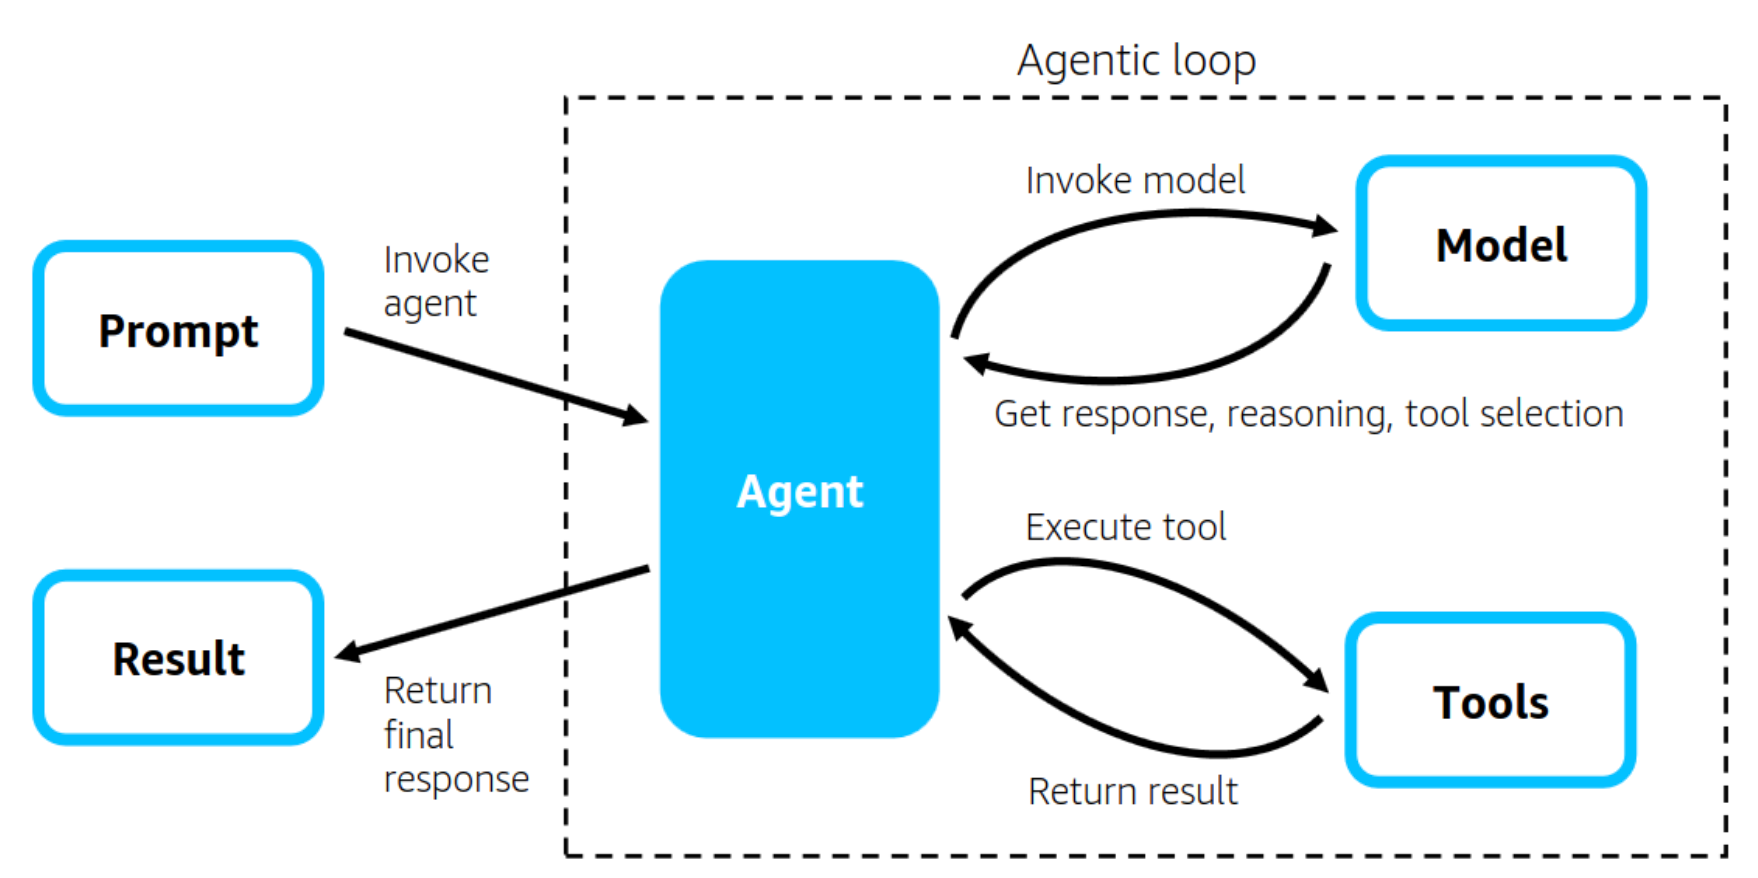



In [ ]:
from strands import Agent, tool
from strands.models import BedrockModel
from strands_tools import retrieve, current_time
import os


bedrock_model = BedrockModel(
    model_id=MODEL_ID,
    temperature=0.3,

)

os.environ["KNOWLEDGE_BASE_ID"] = kb_id
os.environ["AWS_REGION"] = region

system_prompt=f"""
You are an Amazon Returns & Refunds assistant.

Do not answer based on your own knowledge.  
Use retrieve tool with Knowledge Based ID = {kb_id} to get relevant policy information.
Retrieve and check the relevant policies firstly.
Use metadata filtering to get policies for proper country where customer had transactions.
[Metadata]
{{
    "country": <ISO2 Country Code> // e.g. "US", "UK", "IN"
}}

When a user asks about returns or refunds, use the content to give accurate advice.
Always be accurate, concise, and do not deviate from known policies.
"""

agent = Agent(
    model=bedrock_model,
    # tools: include the faq retriever and maybe built-in tools like http_request
    tools=[retrieve, current_time],
    system_prompt=system_prompt)

In [ ]:
# Ask a question

query = ("I bought a Kindle Book three days ago by accident in India."
        "I want to get a refund, what date is the ETA if I request it now?")

resp_structured = agent(
    f"{query}\n\n Please reply in JSON with keys: policy_summary, steps, waiting_time."
)

## Understanding MCP (Model Context Protocol)

The **Model Context Protocol (MCP)** is an open protocol that standardizes how AI models interact with tools, data sources, and external systems in a secure and structured way.  

It allows language models to:
- Access real-time or external data sources dynamically.  
- Interact with specialized tools (like databases, APIs, or custom apps).  
- Maintain consistent context across multiple model invocations.  

In practice, MCP serves as a **bridge between the model and its environment**, enabling multi-agent collaboration, tool execution, and context sharing — all while maintaining isolation and reproducibility.  

The following code demonstrates how to initialize and interact with MCP within this notebook environment.


In [ ]:
from mcp import StdioServerParameters, stdio_client
from strands.tools.mcp import MCPClient
import boto3
from strands import Agent, tool

# Get the current session credentials
credentials = session.get_credentials()

aws_loc_client = MCPClient(
    lambda: stdio_client(
        StdioServerParameters(
            command="uvx",
            args=["awslabs.aws-location-mcp-server@latest"],
            env={
              "AWS_ACCESS_KEY_ID": credentials.access_key,
              "AWS_SECRET_ACCESS_KEY": credentials.secret_key,
              "AWS_SESSION_TOKEN": credentials.token,
              "AWS_REGION": region,
              "FASTMCP_LOG_LEVEL": "ERROR"
            }
        )
    )
)

with aws_loc_client:
    agent = Agent(
        model=bedrock_model,
        # tools: include the faq retriever and maybe built-in tools like http_request
        tools=[retrieve, current_time]+aws_loc_client.list_tools_sync(),
        system_prompt=system_prompt)
    agent("I am returning a product from 94566, find nearest Wholefood to return it.")


#### 3. Security with Guardrails

## Understanding Amazon Bedrock Guardrails

**Amazon Bedrock Guardrails** provide a configurable safety and governance layer for generative AI applications built on Bedrock.  
They help ensure that AI interactions stay **safe, compliant, and aligned** with organizational or regulatory standards.

Guardrails allow developers to:
- Define **content filters** for categories like hate speech, violence, or sensitive topics.  
- Enforce **data privacy rules** (e.g., mask PII or restrict outputs containing certain terms).  
- Apply **tone, style, or topic constraints** to keep model outputs on-brand and contextually appropriate.  
- Integrate **structured rules** for different data types (text, images, or geospatial data).  

By applying guardrails, developers can maintain **responsible AI practices** while giving users a reliable, predictable experience.  

The following code demonstrates how to create, configure, and test Bedrock Guardrails programmatically.


In [ ]:
# Block specific topics and content
from utils.guardrail import create_guardrail_if_not_exists, create_guardrail_version

topic_policy = {
                    "topicsConfig": [
                        {
                            'name': 'irrelevant-requests',
                            'definition': "Investment-related information, including Amazon's sales, revenue, and profit data.",
                            'type': 'DENY'
                        },
                    ]
                }

content_policy = {
                'filtersConfig': [
                    {'type': 'HATE', 'inputStrength': 'HIGH', 'outputStrength': 'HIGH'},
                    {'type': 'INSULTS', 'inputStrength': 'HIGH', 'outputStrength': 'HIGH'},
                    {'type': 'SEXUAL', 'inputStrength': 'HIGH', 'outputStrength': 'HIGH'},
                    {'type': 'VIOLENCE', 'inputStrength': 'HIGH', 'outputStrength': 'HIGH'},
                    {'type': 'MISCONDUCT', 'inputStrength': 'HIGH', 'outputStrength': 'HIGH'},
                    {'type': 'PROMPT_ATTACK', 'inputStrength': 'HIGH', 'outputStrength': 'NONE'}
                ]
            }

guardrail_id = create_guardrail_if_not_exists(
    session,
    description="Guardrail for Return & Refund Assistant",
    blocked_input_messaging="Your request is not relevant to my service.",
    blocked_output_messaging="This response has been blocked.",
    topic_policy=topic_policy,
    content_policy=content_policy,
    guardrail_name="AmazonReturnRefundAssistantGuardrail", 
    region_name=region
)

guardrail_version = create_guardrail_version(
    session,
    guardrail_id, 
    description="Production version 1.0", 
    region_name=region
)

In [ ]:
import boto3
import json

bedrock = boto3.client("bedrock-runtime")

# Check if the guardrail works. Irrelevant questions should not be answered.
query = "How many Apple products have been sold in Amazon.com?"
response = bedrock.converse(
    modelId=MODEL_ID,
    guardrailConfig={
        "guardrailIdentifier": guardrail_id,
        "guardrailVersion": guardrail_version
    },
    messages=[
        {"role": "user", "content": [{"text": query}]}
    ]
)

print("Question:", query)
print("Model Response:", response["output"]["message"]["content"][0]["text"])
print("Stop Reason:", response["stopReason"])
print("=" * 60)

# It should answer for the valid questions.
query = "How do I return the books I purchased by accident?"
response = bedrock.converse(
    modelId=MODEL_ID,
    guardrailConfig={
        "guardrailIdentifier": guardrail_id,
        "guardrailVersion": guardrail_version
    },
    messages=[
        {"role": "user", "content": [{"text": query}]}
    ]
)

print("Question:", query)
print("Model Response:", response["output"]["message"]["content"][0]["text"])
print("Stop Reason:", response["stopReason"])


In [ ]:
# Irrelevant question for the agent.
query = "How many Apple products have been sold in Amazon.com?"

bedrock_model = BedrockModel(
    model_id=MODEL_ID,
    temperature=0.0,
    guardrail_id=guardrail_id,         # Your Bedrock guardrail ID
    guardrail_version=guardrail_version
)

agent = Agent(
    model=bedrock_model,
    tools=[retrieve])

print("\nQuestion: ", query)
response = agent(query)

print("\n", "="*60)

# Ask a valid question
query = "Can I return iPhone?"
print("\nQuestion:", query)
response = agent(query)
print(response)